In [11]:
from sklearn.neighbors import KNeighborsClassifier as kNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree

import numpy as np

# import dataset packages
from sklearn.datasets import make_blobs

# import from project files
from utils import plot_2d, test_model

## Dataset Generation ## 


### Decision Trees ###
General: 
- The key idea is to use a decision tree to partition the data space into dense regions and sparse regions.


Advantages:
- Good with High Level Data: e.g. age, income
- Cases of missing values and outliers have less significance on the decision tree’s data.


Disadvantages:
- Bad with Low Level Data: data with many predictors/inputs
- Trees can overfit: Overfitting increases with depth of tree

In [12]:
# min_samples_split best between [2, 40] (see https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)
# if value too small trees tend to overfit
# Imbalanced class problem: because then regions in which the minority class will be in majority 
# will be very small so min_samples_split should be lower


# kNN vs Decision Trees #

### kNN outperforming Decision Trees ###

Dataset-NN consists of two classes, that each have multiple individual and randomly placed clusters. kNN is able to approximate them very well, because it can adapt to arbitrarily formed decision boundaries. Decision Trees perform worse. Due to their nature of splitting the data space into regions, which only split the dataset into horizontal and vertical lines, they are not able to approximate the dataset as well as kNN.

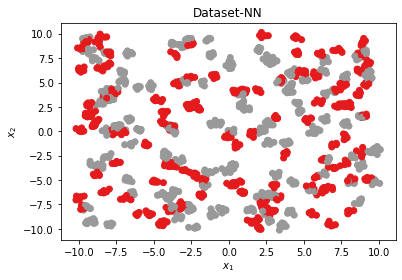

In [13]:
# Generate dataset
def data_nn():

    nn_X, nn_y = make_blobs(
        n_samples=1500,
        n_features=2,
        centers=220,
        cluster_std=.16,
        random_state=42
    )
    nn_y = nn_y % 2 # to reduce the amount of different labels to 2

    return nn_X, nn_y

nn_X, nn_y = data_nn()
plot_2d(nn_X, nn_y, 'Dataset-NN')

kNN Performance on Dataset-NN:
AUC score: 0.921


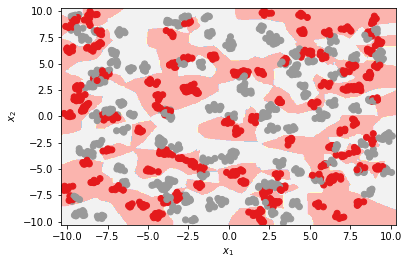

Decision Trees Performance on Dataset-NN:
AUC score: 0.842


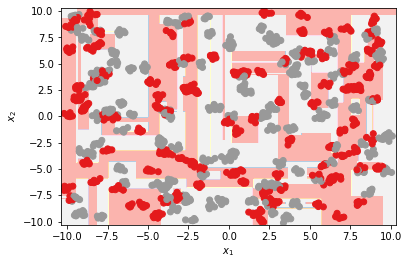

In [14]:
print('kNN Performance on Dataset-NN:')
knn = kNC(n_neighbors=3)
test_model(knn, nn_X, nn_y)

print('Decision Trees Performance on Dataset-NN:')
dtree=DTC(criterion='entropy', max_depth=25, min_samples_split=2)
test_model(dtree, nn_X, nn_y)


### Decision Trees outperforming kNN ###

Dataset-DT consists of two classes, that are distributed in vertical lines, i.e., columns, alternating between the classes. All datapoints have the same distance to oneanother. Decision Trees can optimally approximate this dataset, because all boundaries are vertical. kNN with lower k almost randomly assigns classes, since the majority of a datapoints 8 closest neighbors belongs to the other class. The best perforance is achieved with k=17, because when looking at neighbors across 5 columns, 3 of the 5 columns belong the class of the data point. 

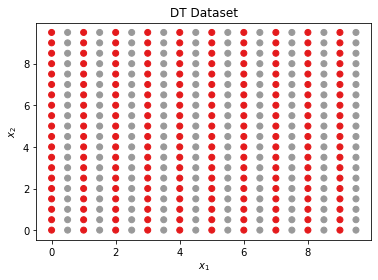

In [15]:
# Generate dataset
def data_dt():  
            
    X = []
    y = []
    for col, i in enumerate(np.arange(0, 10, 10/20, dtype=float)):
        for j in np.arange(0, 10, 10/20, dtype=float):
            X.append(np.array([i, j]))
            y.append(col % 2)
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y

dt_X, dt_y = data_dt()
plot_2d(dt_X, dt_y, 'Dataset-DT')

kNN Performance on Dataset-DT:
AUC score: 0.624


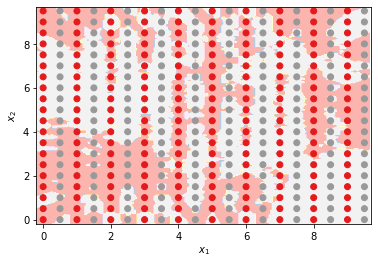

Decision Trees Performance on Dataset-DT:
AUC score: 1.000


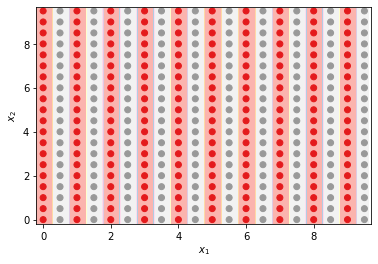

[Text(0.7777777777777778, 0.975, 'X[0] <= 9.25\nentropy = 1.0\nsamples = 268\nvalue = [136, 132]'),
 Text(0.6666666666666666, 0.925, 'X[0] <= 8.75\nentropy = 0.996\nsamples = 254\nvalue = [136, 118]'),
 Text(0.5555555555555556, 0.875, 'X[0] <= 8.25\nentropy = 1.0\nsamples = 239\nvalue = [121, 118]'),
 Text(0.4444444444444444, 0.825, 'X[0] <= 7.75\nentropy = 0.996\nsamples = 225\nvalue = [121, 104]'),
 Text(0.3333333333333333, 0.775, 'X[0] <= 7.25\nentropy = 1.0\nsamples = 211\nvalue = [107, 104]'),
 Text(0.2222222222222222, 0.725, 'X[0] <= 0.25\nentropy = 0.995\nsamples = 197\nvalue = [107, 90]'),
 Text(0.1111111111111111, 0.675, 'entropy = 0.0\nsamples = 13\nvalue = [13, 0]'),
 Text(0.3333333333333333, 0.675, 'X[0] <= 0.75\nentropy = 1.0\nsamples = 184\nvalue = [94, 90]'),
 Text(0.2222222222222222, 0.625, 'entropy = 0.0\nsamples = 13\nvalue = [0, 13]'),
 Text(0.4444444444444444, 0.625, 'X[0] <= 1.25\nentropy = 0.993\nsamples = 171\nvalue = [94, 77]'),
 Text(0.3333333333333333, 0.575, 

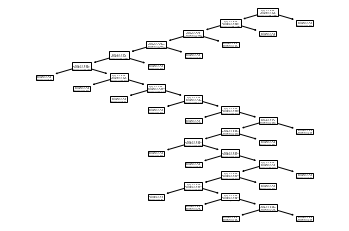

In [17]:
print('kNN Performance on Dataset-DT:')
knn = kNC(n_neighbors=17)
test_model(knn, dt_X, dt_y)

print('Decision Trees Performance on Dataset-DT:')
dtree=DTC(criterion='entropy', max_depth=None, min_samples_split=2)
test_model(dtree, dt_X, dt_y)